In [2]:
#data manipulation
import numpy as np
import pandas as pd
import re
#visualization
import matplotlib.pyplot as plt
plt.style.use("seaborn")#use seaborn style
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

#modeling and forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster, load_forecaster

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Dataset load

In [3]:
def prep_data():
    #import data
    df = pd.read_csv("../bergen_florida_temperature_1957-2022.csv",\
                    sep=";", converters={"Tid(norsk normaltid)":str},
                    decimal=",")
    #rename columns
    df.rename(columns={"Tid(norsk normaltid)": "Date", "Middeltemperatur (mnd)": "mean_temp", 
                        "Middeltemperatur, avvik fra normalen 1991-2020 (mnd)": "mean_temp_deviation",
                        "Maksimumstemperatur (mnd)": "max_temp", "Minimumstemperatur (mnd)": "min_temp"}, 
                        inplace=True)

    #seperate month and year from Date column 
    # frm (MM.YYYY) to mm and YYYY
    month = []
    year = []
    for i in range(len(df)):
        month.append( re.findall( r'[0-9]+', str( df["Date"][i] ) ) [0] )
        year.append( re.findall( r'[0-9]+', str( df["Date"][i] ) ) [1] )

    #add month and year list into df 
    df["month"] = month
    df["year"] = year

    #convert month and year into numeric
    df["year"] = df["year"].astype("int")
    df["month"] = df["month"].astype("int")

    #create datatime column using month year
    #and new day column with 1
    df["day"] = "01"
    df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day))

    #copy df for neuralprophet
    df_np = df.copy()

    return df, df_np

df, df_np = prep_data()
df.head()

,Navn,Stasjon,Date,mean_temp,mean_temp_deviation,max_temp,min_temp,month,year,day,date
0,Bergen - Florida,SN50540,01.1957,3.8,1.2,9.6,-5.0,1,1957,01,1957-01-01
1,Bergen - Florida,SN50540,02.1957,2.3,0.0,9.6,-5.6,2,1957,01,1957-02-01
2,Bergen - Florida,SN50540,03.1957,5.4,1.6,14.5,-2.2,3,1957,01,1957-03-01
3,Bergen - Florida,SN50540,04.1957,6.3,-0.9,14.1,-1.0,4,1957,01,1957-04-01
4,Bergen - Florida,SN50540,05.1957,9.1,-1.6,20.8,1.4,5,1957,01,1957-05-01


In [4]:
df = df.set_index("date")


In [5]:
df = df.asfreq("MS")

Rename df["mean_temp"] to df["y"]

In [6]:
df = df.rename(columns={"mean_temp": "y"})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 789 entries, 1957-01-01 to 2022-09-01
Freq: MS
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Navn                 789 non-null    object 
 1   Stasjon              789 non-null    object 
 2   Date                 789 non-null    object 
 3   y                    789 non-null    float64
 4   mean_temp_deviation  789 non-null    float64
 5   max_temp             789 non-null    float64
 6   min_temp             789 non-null    float64
 7   month                789 non-null    int64  
 8   year                 789 non-null    int64  
 9   day                  789 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 67.8+ KB


Check against missing values

In [8]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')
df = df.fillna(method="ffill")

Number of rows with missing values: 0.0


In [9]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [10]:
df.tail(12)

,Navn,Stasjon,Date,y,mean_temp_deviation,max_temp,min_temp,month,year,day
date,,,,,,,,,,
2021-10-01,Bergen - Florida,SN50540,10.2021,9.8,1.2,16.4,-0.3,10,2021,01
2021-11-01,Bergen - Florida,SN50540,11.2021,6.0,0.7,13.4,-6.5,11,2021,01
2021-12-01,Bergen - Florida,SN50540,12.2021,2.7,-0.4,9.8,-5.5,12,2021,01
2022-01-01,Bergen - Florida,SN50540,01.2022,4.3,1.7,9.9,-2.7,1,2022,01
2022-02-01,Bergen - Florida,SN50540,02.2022,3.3,1.0,8.9,-2.3,2,2022,01
2022-03-01,Bergen - Florida,SN50540,03.2022,6.3,2.5,14.9,-2.4,3,2022,01
2022-04-01,Bergen - Florida,SN50540,04.2022,7.2,0.0,20.6,-2.8,4,2022,01
2022-05-01,Bergen - Florida,SN50540,05.2022,10.3,-0.4,22.0,1.5,5,2022,01
2022-06-01,Bergen - Florida,SN50540,06.2022,14.3,0.7,29.9,7.9,6,2022,01


Split data into train-test using last 60 steps/months

Train dates : 1957-01-01 00:00:00 --- 2018-09-01 00:00:00  (n=741)
Test dates  : 2018-10-01 00:00:00 --- 2022-09-01 00:00:00  (n=48)


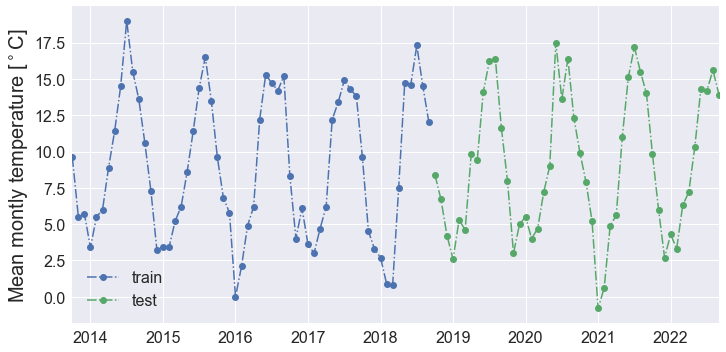

In [11]:
steps = 48
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(10, 5))
data_train['y'][-60:].plot(ax=ax, label='train', linestyle='-.', marker='o')
data_test['y'].plot(ax=ax, label='test', linestyle='-.', marker='o')
ax.legend(loc='lower left');
plt.ylabel("Mean montly temperature [$^\circ$C]")
plt.xlabel("")
plt.tight_layout()
plt.show()

Create and train forecaster using ForecasterAutoreg method

In [12]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=0),
                #regressor = GradientBoostingRegressor(random_state=0),
                #transformer_y= StandardScaler(),
                lags      = 6
)

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=0) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1957-01-01 00:00:00'), Timestamp('2018-09-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-12 20:07:57 
Last fit date: 2022-11-12 20:07:57 
Skforecast version: 0.5.1 
Python version: 3.9.10 

Predictions: 36 months into the future

In [13]:
steps = 60
predictions = forecaster.predict(steps=steps)
predictions.tail(12)

2022-10-01     8.759
2022-11-01     5.162
2022-12-01     3.548
2023-01-01     2.696
2023-02-01     1.358
2023-03-01     2.239
2023-04-01     6.574
2023-05-01    10.612
2023-06-01    13.091
2023-07-01    14.886
2023-08-01    14.660
2023-09-01    12.541
Freq: MS, Name: pred, dtype: float64

Plot predictions

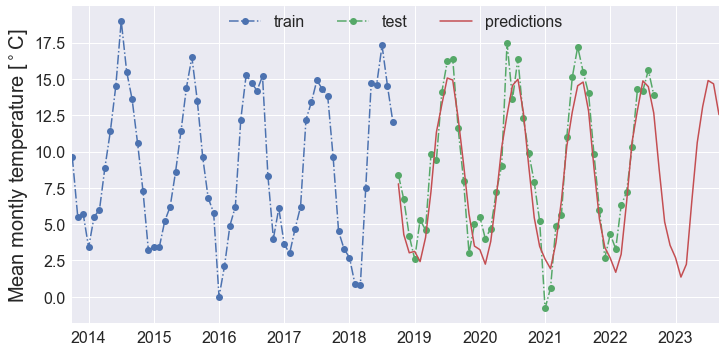

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
data_train['y'][-60:].plot(ax=ax, label='train', linestyle='-.', marker='o')
data_test['y'].plot(ax=ax, label='test', linestyle='-.', marker='o')
predictions.plot(ax=ax, label='predictions')
ax.legend(loc="upper center", ncol=3, borderaxespad=0.1);
plt.ylabel("Mean montly temperature [$^\circ$C]")
plt.xlabel("")
plt.tight_layout()
#plt.show()
plt.savefig("./skforecast_future_forecast.pdf")

Prediction error in the test set: mean squared error is used

In [15]:
predictions.shape

(60,)

In [16]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions[:48]
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 3.0421926041666683


Hyperparameter tuning:

The trained ForecasterAutoreg uses a 6 lag time window and a Random Forest model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the Skforecast library provides the grid_search_forecaster function. It compares the results obtained with each model configuration.

In [17]:
steps = 48
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=0),
                #regressor = GradientBoostingRegressor(random_state=0),
                #transformer_y = StandardScaler(),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:20<00:00, 70.01s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.9474689203432645



In [18]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",2.947469,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",2.969888,5,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",3.000773,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",3.220919,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",3.506794,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",3.538585,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",3.561016,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",3.671111,10,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",3.797981,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",3.815747,3,100


Final model: 

RandomForestRegressor with max_depth = 5, n_estimators = 500, and lags = 3

In [19]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=0)
#regressor = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=0)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                #transformer_y = StandardScaler(),
                lags      = 3
             )

forecaster.fit(y=data_train['y'])

In [36]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=60)

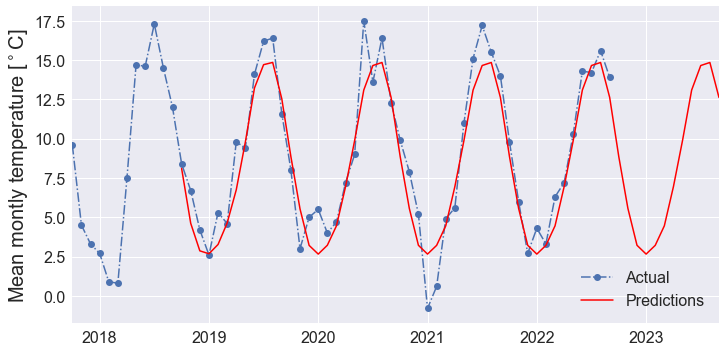

In [38]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
df['y'][-60:].plot(ax=ax, label='Actual', linestyle='-.', marker='o')
#data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='Predictions', color='red')
ax.legend(loc="lower right");
plt.ylabel("Mean montly temperature [$^\circ$C]")
plt.xlabel("")
plt.tight_layout()
#plt.show()
plt.savefig("./skforecast_future_forecast_v1.pdf")

In [22]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions[:48]
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 2.625464453397425


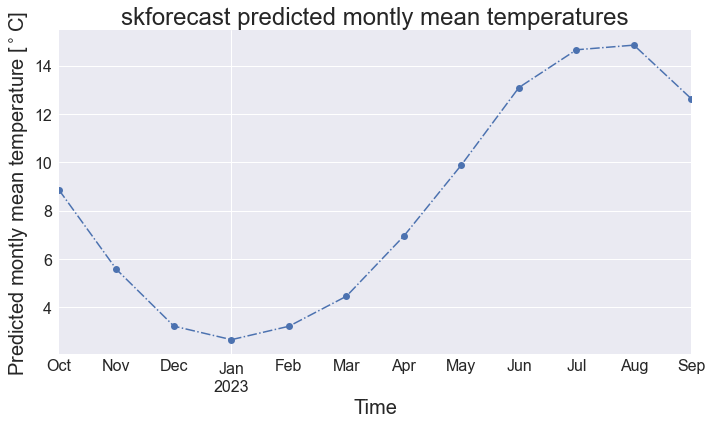

In [23]:
predictions[-12:]
predictions[-12:].plot(linestyle='-.', marker='o')
plt.title("skforecast predicted montly mean temperatures")
plt.xlabel("Time")
plt.ylabel("Predicted montly mean temperature [$^\circ$C]")
plt.tight_layout()
plt.show()

In [24]:
predictions[-12:]

2022-10-01     8.853707
2022-11-01     5.564342
2022-12-01     3.215511
2023-01-01     2.656357
2023-02-01     3.211584
2023-03-01     4.454072
2023-04-01     6.948264
2023-05-01     9.889320
2023-06-01    13.092227
2023-07-01    14.654029
2023-08-01    14.846620
2023-09-01    12.622555
Freq: MS, Name: pred, dtype: float64

#### Backtesting

For this example, a backtesting with refit strategy is followed. Internally, the process that the function applies is:

- In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are used to validate the predictions of this first model.

- In the second iteration, the model is retrained by adding, to the initial training set, the previous 36 validation observations (87 + 36). In the same way, the next 36 observations are established as the new validation set.

- This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.


In [25]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 12*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df['y'],
                                    initial_train_size = len(df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 753
Number of observations used for backtesting: 36
    Number of folds: 1
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1957-01-01 00:00:00 -- 2019-09-01 00:00:00  (n=753)
    Validation: 2019-10-01 00:00:00 -- 2022-09-01 00:00:00  (n=36)

Backtest error: 2.7751348195527545


In [26]:
#predictions_backtest.loc[predictions_backtest.index > "2021"]

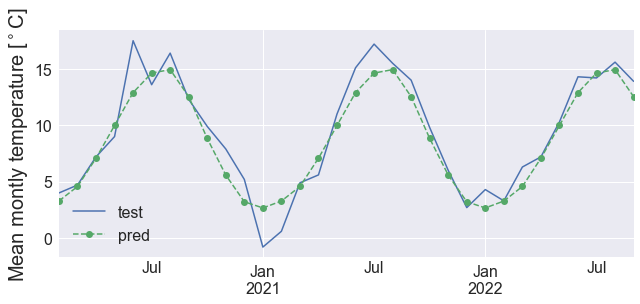

In [27]:
fig, ax = plt.subplots(figsize=(9, 4))
df.loc[df.index > "2020", 'y'].plot(ax=ax, label='test')
predictions_backtest.loc[predictions_backtest.index > "2020"].plot(ax=ax, label='predictions', linestyle="--", marker="o")
ax.legend();
plt.ylabel("Mean montly temperature [$^\circ$C]")
plt.xlabel("")
plt.tight_layout()
plt.show()

Predictors importance


Since the ForecasterAutoreg object uses Scikit-learn models, the importance of predictors can be accessed once trained. When the regressor used is a LinearRegression(), Lasso() or Ridge(), the coefficients of the model reflect their importance. In GradientBoostingRegressor() or RandomForestRegressor() regressors, the importance of predictors is based on impurity.

Note: the get_feature_importance() method only returns values if the regressor used within the forecaster has the attribute coef_ or feature_importances_.

In [28]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.776111
1,lag_2,0.016422
2,lag_3,0.207467


In [29]:
backtesting_forecaster

<function skforecast.model_selection.model_selection.backtesting_forecaster(forecaster, y: pandas.core.series.Series, steps: int, metric: Union[str, <built-in function callable>, list], initial_train_size: Optional[int], fixed_train_size: bool = True, exog: Union[pandas.core.series.Series, pandas.core.frame.DataFrame, NoneType] = None, refit: bool = False, interval: Optional[list] = None, n_boot: int = 500, random_state: int = 123, in_sample_residuals: bool = True, verbose: bool = False) -> Tuple[Union[float, list], pandas.core.frame.DataFrame]>

In [30]:
#forecasts
#predictions_backtest

Compare predictions with https://seklima.met.no/observations/ 